This runs DeepExplainer with the model trained on simualted genomic data from the DeepLIFT repo (https://github.com/kundajelab/deeplift/blob/master/examples/genomics/genomics_simulation.ipynb), using a dynamic reference (i.e. the reference varies depending on the input sequence; in this case, the reference is a collection of dinucleotide-shuffled versions of the input sequence)

Pull in the relevant data

In [1]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

Load the data

In [2]:
! pip install simdna

In [3]:
import simdna.synthetic as synthetic
import gzip
data_filename = "sequences.simdata.gz"

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

In [4]:
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seq) for seq in data.sequences])

Load the model

In [5]:
from keras.models import model_from_json

#load the keras model
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

Using TensorFlow backend.
W0702 16:10:05.481790 140736164868992 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 16:10:05.494989 140736164868992 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 16:10:05.497503 140736164868992 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 16:10:05.528893 140736164868992 deprecation_wrapper.py:119] From /Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg

Install the deeplift package for the dinucleotide shuffling and visualzation code

In [6]:
!pip install deeplift

### Compute importance scores

Define the function that generates the reference, in this case by performing a dinucleotide shuffle of the given input sequence

In [7]:
from deeplift.dinuc_shuffle import dinuc_shuffle, traverse_edges, shuffle_edges, prepare_edges
from collections import Counter

def onehot_dinuc_shuffle(s): 
    s = np.squeeze(s)
    argmax_vals = "".join([str(x) for x in np.argmax(s, axis=-1)])
    shuffled_argmax_vals = [int(x) for x in traverse_edges(argmax_vals,                          
                            shuffle_edges(prepare_edges(argmax_vals)))]    
    to_return = np.zeros_like(s)    
    to_return[list(range(len(s))), shuffled_argmax_vals] = 1    
    return to_return

#This generates 100 references per sequence
#In my (Avanti Shrikumar) experience,
# 100 references per sequence is on the high side; around 10 work well in practice
# I am using 100 references here just for demonstration purposes.
shuffle_several_times = lambda s: np.array([onehot_dinuc_shuffle(s) for i in range(100)])

Run DeepExplainer with the dynamic reference function

W0702 16:10:10.309796 140736164868992 deprecation.py:323] From /Users/avantishrikumar/Research/shap/shap/explainers/deep/deep_tf.py:491: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Actual contributions


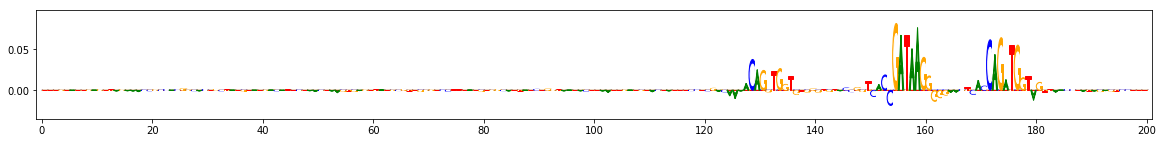

Hypothetical contributions


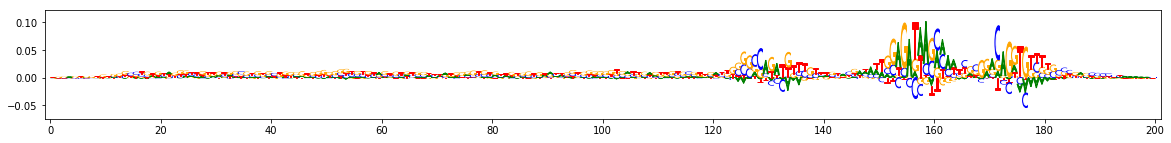

Actual contributions


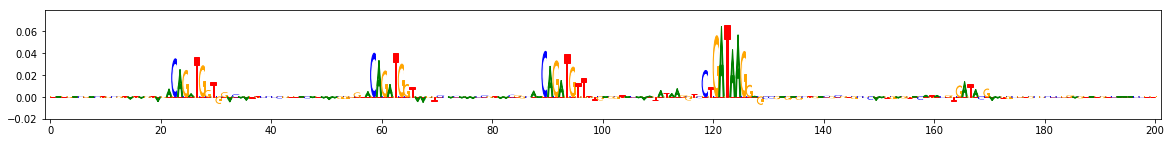

Hypothetical contributions


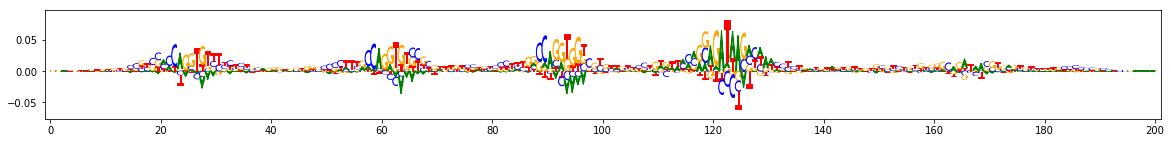

Actual contributions


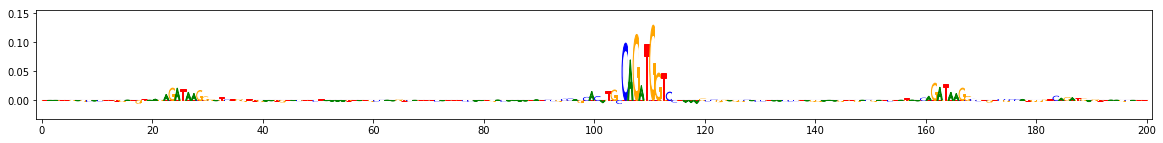

Hypothetical contributions


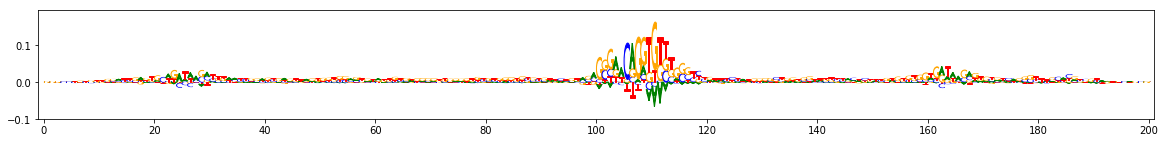

In [8]:
%matplotlib inline
from importlib import reload
from deeplift.visualization import viz_sequence
import shap
import shap.explainers.deep.deep_tf
reload(shap.explainers.deep.deep_tf)
reload(shap.explainers.deep)
reload(shap.explainers)
reload(shap)
import numpy as np
np.random.seed(1)
import random

#This combine_mult_and_diffref function can be used to generate hypothetical
# importance scores, which can be thought of as quick estimates of what the
# contribution *would have been* if a different base were present. Hypothetical
# scores are used as input to the importance score clustering algorithm
# TF-MoDISco (https://github.com/kundajelab/tfmodisco)
# Hypothetical importance scores are discussed more in this pull request:
#  https://github.com/kundajelab/deeplift/pull/36
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    to_return = []
    for l in range(len(mult)):
        projected_hypothetical_contribs = np.zeros_like(bg_data[l]).astype("float")
        assert len(orig_inp[l].shape)==2
        for i in range(orig_inp[l].shape[-1]):
            hypothetical_input = np.zeros_like(orig_inp[l]).astype("float")
            hypothetical_input[:,i] = 1.0
            difference_from_reference = (hypothetical_input[None,:,:]-bg_data[l])
            hypothetical_contribs = difference_from_reference*mult[l]
            projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1) 
        to_return.append(np.mean(projected_hypothetical_contribs,axis=0))
    return to_return

seqs_to_explain = onehot_data[[0,3,9]] #these three are positive for task 0
dinuc_shuff_explainer = shap.explainers.deep.deep_tf.TFDeepExplainer(
    (keras_model.input, keras_model.output[:,0]), shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)
shap_explanations = dinuc_shuff_explainer.shap_values(seqs_to_explain)

for hypimpscores,orig_seq in zip(shap_explanations,seqs_to_explain):
    print("Actual contributions")
    # (The actual importance scores can be computed using an element-wise product of
    #  the hypothetical importance scores and the actual importance scores)
    viz_sequence.plot_weights(hypimpscores*orig_seq, subticks_frequency=20)
    print("Hypothetical contributions")
    viz_sequence.plot_weights(hypimpscores, subticks_frequency=20)